# ME233 Final Project

# 0.0 Load python packages

In [ ]:
# # the current colab versions are not compatible with this notebook so we need to install these older package versions
!pip install matplotlib==3.2.2
!pip install tensorflow==2.12.0
!pip install numpy==1.23.5
!pip install pandas==1.5.3
# do not restart the runtime until all packages have been installed (hit cancel on the pop-up)!!
# the errors in red that print out can be ignored; they will not affect this code

# 0.1 Check Python Package

In [ ]:
# import necessary python packages
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.backend as K
import json
import pandas as pd
import os
import copy
from sklearn.metrics import r2_score
import random

# set random seed
seed = 42
os.environ['PYTHONHASHSEED']=str(seed)
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.keras.utils.set_random_seed(seed)

# Check Versions
print('Numpy: ' + np.__version__) # 1.23.5
print('Matplotlib: ' + matplotlib.__version__) # 3.2.2
print('Tensorflow: ' + tf.__version__) # 2.12.0
print('Keras: ' + keras.__version__)
print('Pandas: ' + pd.__version__) # 1.5.3

Numpy: 1.23.5
Matplotlib: 3.2.2
Tensorflow: 2.12.0
Keras: 2.12.0
Pandas: 1.5.3


# 0.2 Mount Drive

In [ ]:
#Import excel file, change to match where you saved the file
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
path = '/content/drive/MyDrive/Project_Code/input/' # change to your path, must be in Google Drive
dfs = pd.read_excel(path + 'CANNsEcoflexDataSelect.xlsx', sheet_name='Sheet1')
# Add muscle data
dfs_muscle = pd.read_excel(path + 'muscle_data.xlsx', sheet_name='Sheet1')

Mounted at /content/drive


make path to save result

In [ ]:
# Make path to save results to
def makeDIR(path):
    if not os.path.exists(path):
        os.makedirs(path)

filename = 'EcoflexCANN'
path2saveRaw = path + 'Results/'+filename+'/RawData'
makeDIR(path2saveRaw)

# 1. load Ecoflex uniaxial tension test data

In [ ]:
# Load data for different Ecoflex test
from sklearn.model_selection import train_test_split
def getStressStrain(Region):

    if Region =='Vol0.3':
        P_18 = dfs.iloc[3:,1].dropna().astype(np.float64).values
        lam_18 = dfs.iloc[3:,0].dropna().astype(np.float64).values

        P_180 = dfs.iloc[3:,3].dropna().astype(np.float64).values
        lam_180 = dfs.iloc[3:,2].dropna().astype(np.float64).values

        P_900 = dfs.iloc[3:,5].dropna().astype(np.float64).values
        lam_900 = dfs.iloc[3:,4].dropna().astype(np.float64).values

    elif Region =='Vol0.2':
        P_18 = dfs.iloc[3:,8].dropna().astype(np.float64).values
        lam_18 = dfs.iloc[3:,7].dropna().astype(np.float64).values

        P_180 = dfs.iloc[3:,10].dropna().astype(np.float64).values
        lam_180 = dfs.iloc[3:,9].dropna().astype(np.float64).values

        P_900 = dfs.iloc[3:,12].dropna().astype(np.float64).values
        lam_900 = dfs.iloc[3:,11].dropna().astype(np.float64).values

    elif Region =='Vol0.1':
        P_18 = dfs.iloc[3:,15].dropna().astype(np.float64).values
        lam_18 = dfs.iloc[3:,14].dropna().astype(np.float64).values

        P_180 = dfs.iloc[3:,17].dropna().astype(np.float64).values
        lam_180 = dfs.iloc[3:,16].dropna().astype(np.float64).values

        P_900 = dfs.iloc[3:,19].dropna().astype(np.float64).values
        lam_900 = dfs.iloc[3:,18].dropna().astype(np.float64).values


    return P_18, lam_18, P_180, lam_180, P_900, lam_900

# Define different loading protocols
def traindata(modelFit_mode):
    if modelFit_mode == "18":
        model_given = model_UT
        lam_18_train, lam_18_test, P_18_train, P_18_test = train_test_split(lam_18, P_18, test_size=0.25, random_state=42)
        input_train = lam_18_train
        output_train = P_18_train
        input_test = lam_18_test
        output_test = P_18_test
        sample_weights = np.array([1.0]*input_train.shape[0])

    elif modelFit_mode == "180":
        model_given = model_UT
        lam_180_train, lam_180_test, P_180_train, P_180_test = train_test_split(lam_180, P_180, test_size=0.25, random_state=42)
        input_train = lam_180_train
        output_train = P_180_train
        input_test = lam_180_test
        output_test = P_180_test
        sample_weights = np.array([1.0]*input_train.shape[0])

    elif modelFit_mode == "900":
        model_given = model_UT
        lam_900_train, lam_900_test, P_900_train, P_900_test = train_test_split(lam_900, P_900, test_size=0.25, random_state=42)
        input_train = lam_900_train
        output_train = P_900_train
        input_test = lam_900_test
        output_test = P_900_test
        sample_weights = np.array([1.0]*input_train.shape[0])
    elif modelFit_mode == "muscle":
        model_given = model_UT
        lam_muscle_train, lam_muscle_test, P_muscle_train, P_muscle_test = train_test_split(lam_muscle, P_muscle, test_size=0.25, random_state=42)
        input_train = lam_muscle_train
        output_train = P_muscle_train
        output_train[output_train<0]=0
        input_test = lam_muscle_test
        output_test = P_muscle_test
        sample_weights = np.array([1.0]*input_train.shape[0])
    elif modelFit_mode == "muscle_comp":
        model_given = model_UT
        input_train = None
        output_train = None
        input_test = lam_muscle
        output_test = P_muscle
        sample_weights = None


    return model_given, input_train, output_train, input_test, output_test, sample_weights

In [ ]:
# Get muscle data
muscle_data_map = {
    'Avg': 0,
    'Calvo': 3,
    'Martins': 6,
    'Yamada': 9,
    'Nie': 12,
}
def getStressStrain_muscle(method):
    column_lam = int(muscle_data_map[method])
    column_P = column_lam + 1
    P_muscle = dfs_muscle.iloc[3:,column_P].dropna().astype(np.float64).values
    lam_muscle = dfs_muscle.iloc[3:,column_lam].dropna().astype(np.float64).values

    return P_muscle, lam_muscle

In [ ]:
# Select Ecoflex to investigate:
Region_test = 'Vol0.1'  # SELECT COMPOSITE TO PLOT
P_18, lam_18, P_180, lam_180, P_900, lam_900 = getStressStrain(Region_test)

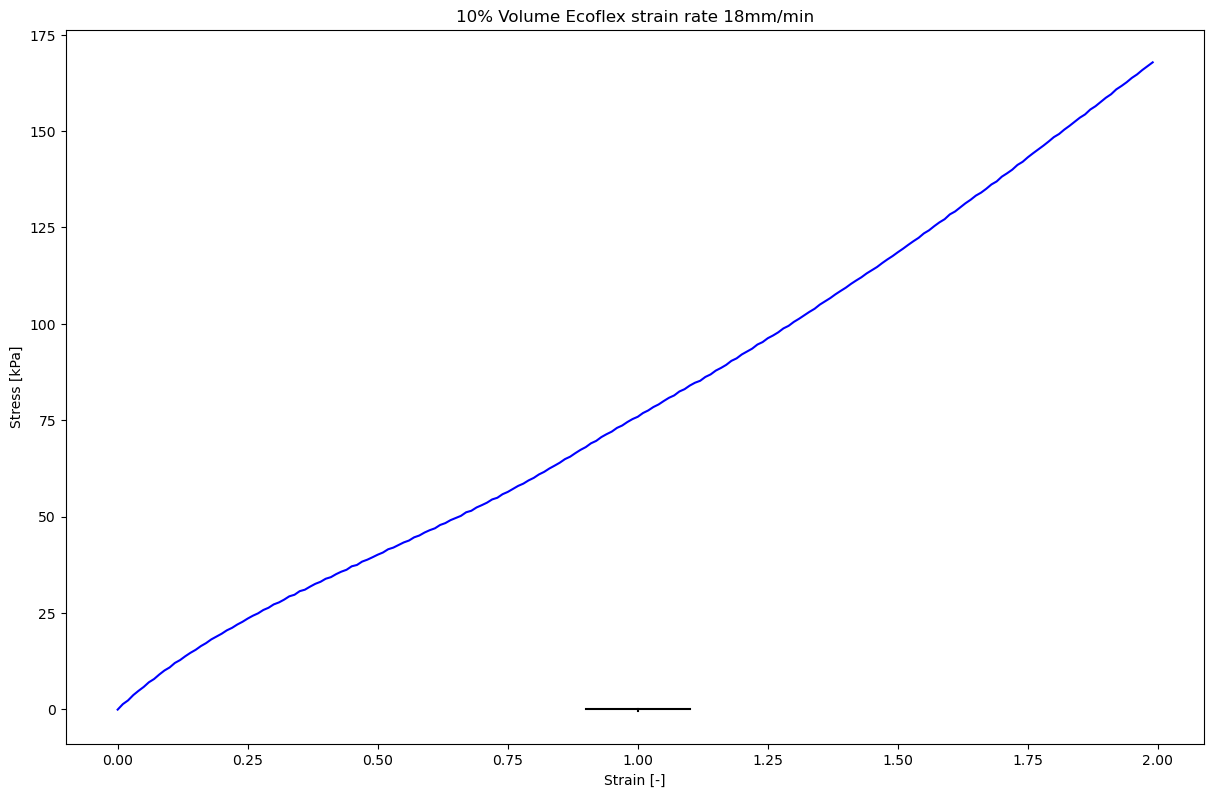

In [ ]:
plt.figure(figsize=(12.5,8.33))
plt.plot(lam_18-1,P_18,color='blue')
plt.plot(np.linspace(0.9, 1.1, 100), np.linspace(0,0,100),'k')
plt.plot(np.linspace(1, 1, 100), np.linspace(-0.5,0.1,100),'k')
plt.xlabel('Strain [-]')
plt.ylabel('Stress [kPa]')
plt.title('10% Volume Ecoflex strain rate 18mm/min') #CHANGE NAME TO COMPOSITE/RATE
plt.tight_layout(pad=2)
plt.savefig(path2saveRaw + '/' + Region_test + '_TenCom' + '.pdf')

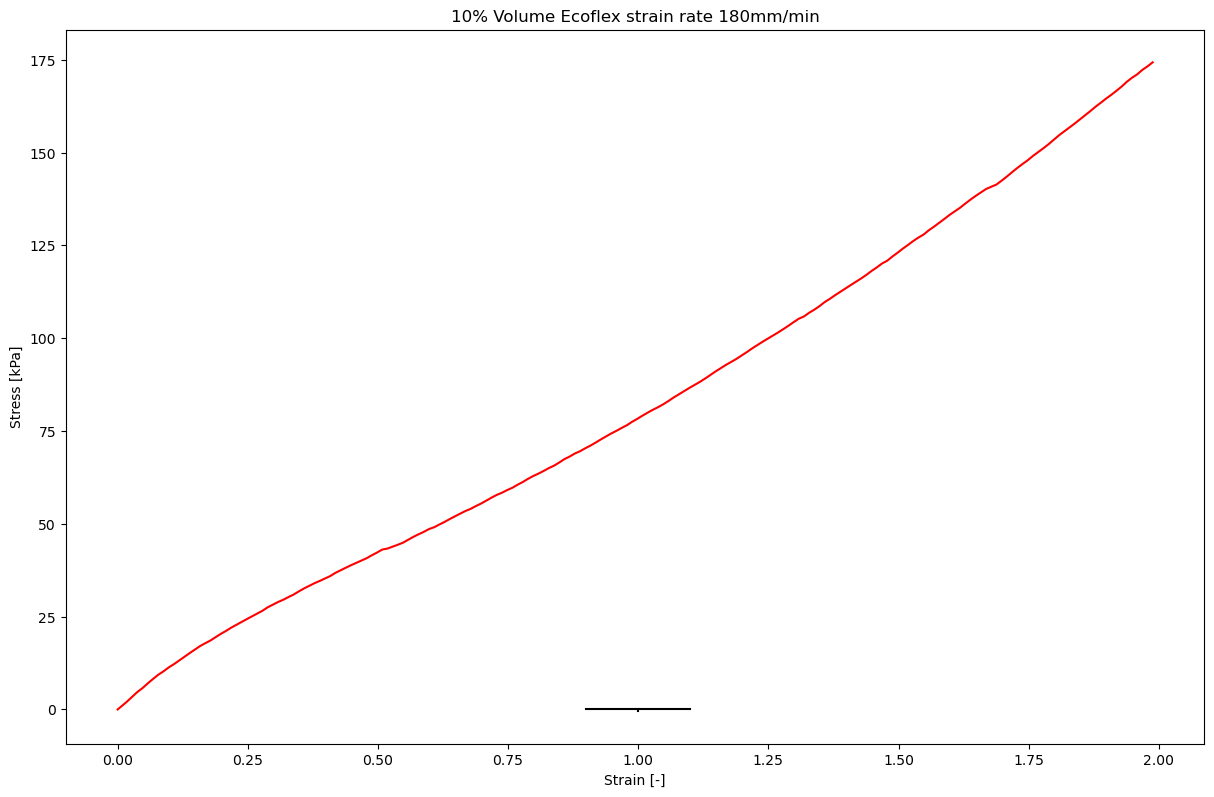

In [ ]:
plt.figure(figsize=(12.5,8.33))
plt.plot(lam_180-1,P_180,color='red')
plt.plot(np.linspace(0.9, 1.1, 100), np.linspace(0,0,100),'k')
plt.plot(np.linspace(1, 1, 100), np.linspace(-0.5,0.1,100),'k')
plt.xlabel('Strain [-]')
plt.ylabel('Stress [kPa]')
plt.title('10% Volume Ecoflex strain rate 180mm/min')
plt.tight_layout(pad=2)
plt.savefig(path2saveRaw + '/' + Region_test + '_TenCom' + '.pdf')

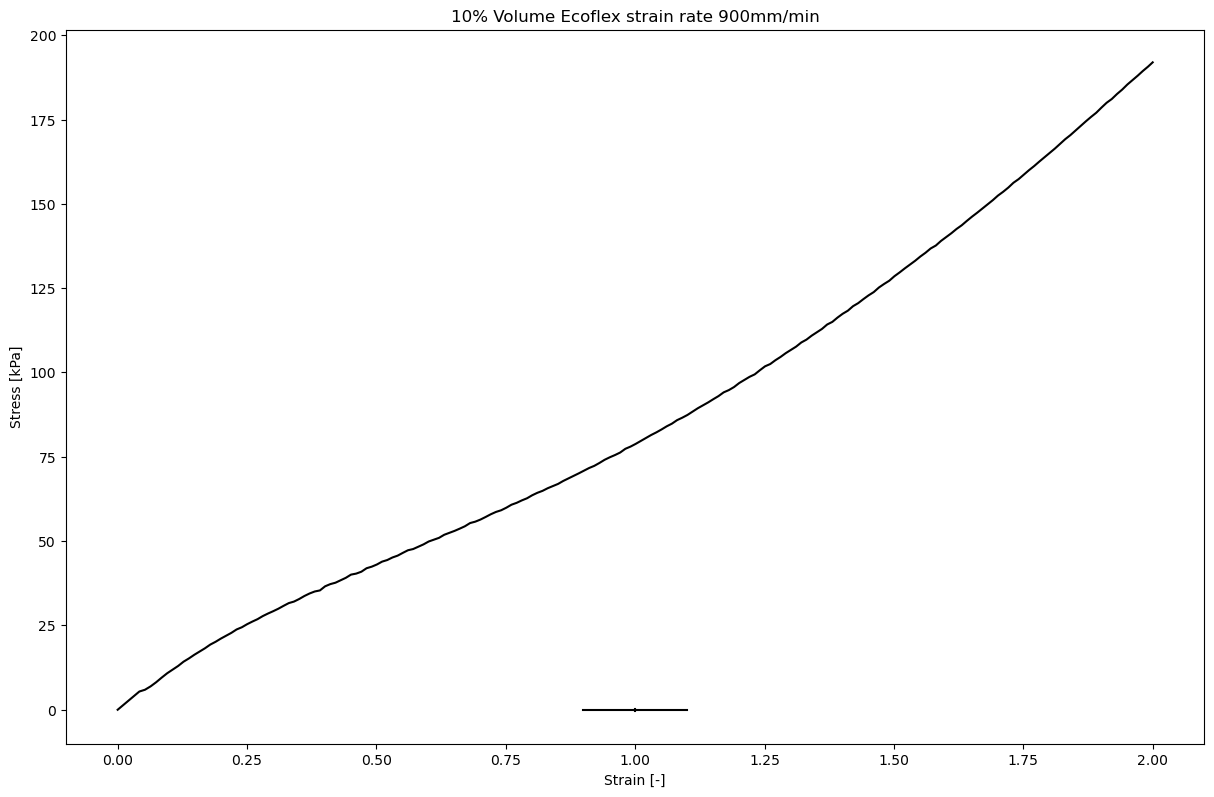

In [ ]:
plt.figure(figsize=(12.5,8.33))
plt.plot(lam_900-1,P_900,color='black')
plt.plot(np.linspace(0.9, 1.1, 100), np.linspace(0,0,100),'k')
plt.plot(np.linspace(1, 1, 100), np.linspace(-0.5,0.1,100),'k')
plt.xlabel('Strain [-]')
plt.ylabel('Stress [kPa]')
plt.title('10% Volume Ecoflex strain rate 900mm/min')
plt.tight_layout(pad=2)
plt.savefig(path2saveRaw + '/' + Region_test + '_TenCom' + '.pdf')

Visualize muscle data

In [ ]:
# Select muscle data
method = 'Yamada'  # method
P_muscle, lam_muscle = getStressStrain_muscle(method)

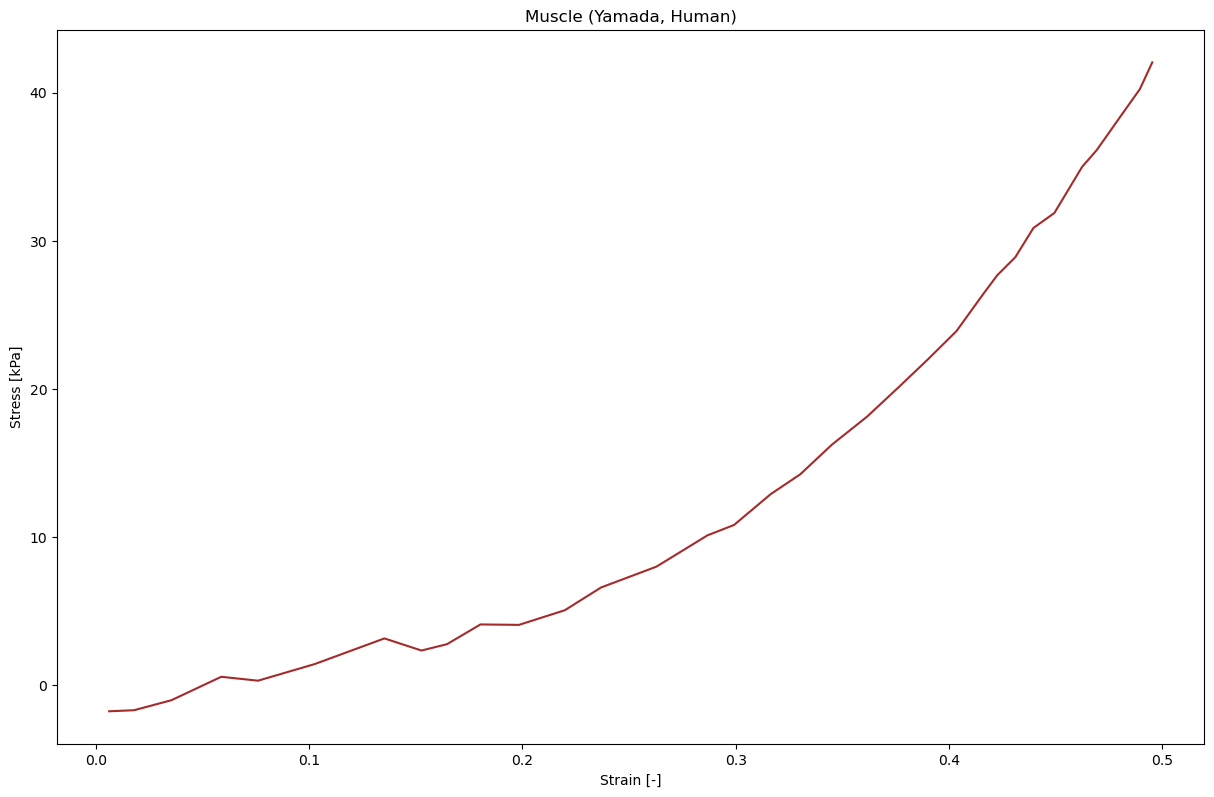

In [ ]:
plt.figure(figsize=(12.5,8.33))
plt.plot(lam_muscle-1, P_muscle,color='brown')
plt.xlabel('Strain [-]')
plt.ylabel('Stress [kPa]')
plt.title('Muscle (Yamada, Human)')
plt.tight_layout(pad=2)
# plt.savefig(path2saveRaw + '/' + Region_test + '_TenCom' + '.pdf')

# 2.0 L1 and L2 regularization with penalty weight

In [ ]:
def regularize(reg, pen):
    if reg == 'L2':
        return keras.regularizers.l2(pen)
    if reg == 'L1':
        return keras.regularizers.l1(pen)

# 2.1 Strain Energy Model - Invariant-based

Define the activation functions and a single Invariant block:

In [ ]:
initializer_exp = tf.keras.initializers.RandomUniform(minval=0., maxval=0.1, seed=np.random.randint(0,10000)) # use random integer as seed
initializer_1 = 'glorot_normal'

# Self defined activation functions for exp term
def activation_Exp(x):
    return 1.0*(tf.math.exp(x) -1.0)
# Self defined activation functions for ln term
def activation_ln(x):
    return -1.0*tf.math.log(1.0 - (x))

# Define network block
def SingleInvNet(I1_ref, idi, reg, pen):

    # input: invariant
    I_1_w11 = keras.layers.Dense(1,kernel_initializer=initializer_1,kernel_constraint=keras.constraints.NonNeg(),
                                 kernel_regularizer=regularize(reg, pen),
                                 use_bias=False, activation=None,name='w'+str(1+idi)+'1')(I1_ref) # no activation
    I_1_w21 = keras.layers.Dense(1,kernel_initializer=initializer_exp,kernel_constraint=keras.constraints.NonNeg(),
                                 kernel_regularizer=regularize(reg, pen),
                                 use_bias=False, activation=activation_Exp,name='w'+str(2+idi)+'1')(I1_ref) # exp activation

    I_1_w31 = keras.layers.Dense(1,kernel_initializer=initializer_1,kernel_constraint=keras.constraints.NonNeg(),
                                 kernel_regularizer=regularize(reg, pen),
                              use_bias=False, activation=activation_ln,name='w'+str(3+idi)+'1')(I1_ref) # ln activation

    # input: invariant^2
    I_1_w41 = keras.layers.Dense(1,kernel_initializer=initializer_1,kernel_constraint=keras.constraints.NonNeg(),
                                 kernel_regularizer=regularize(reg, pen),
                                 use_bias=False, activation=None,name='w'+str(4+idi)+'1')(tf.math.square(I1_ref)) # no activation
    I_1_w51 = keras.layers.Dense(1,kernel_initializer=initializer_exp,kernel_constraint=keras.constraints.NonNeg(),
                                 kernel_regularizer=regularize(reg, pen),
                                 use_bias=False, activation=activation_Exp,name='w'+str(5+idi)+'1')(tf.math.square(I1_ref)) # exp activation
    I_1_w61 = keras.layers.Dense(1,kernel_initializer=initializer_1,kernel_constraint=keras.constraints.NonNeg(),
                                 kernel_regularizer=regularize(reg, pen),
                              use_bias=False, activation=activation_ln,name='w'+str(6+idi)+'1')(tf.math.square(I1_ref)) # ln activation

    collect = [I_1_w11, I_1_w21, I_1_w31, I_1_w41, I_1_w51, I_1_w61]
    collect_out = tf.keras.layers.concatenate(collect, axis=1)

    return collect_out

Define the strain energy keras submodel

In [ ]:
def StrainEnergyCANN_invariant(reg, pen):

    # Inputs defined
    I1_in = tf.keras.Input(shape=(1,), name='I1')
    I2_in = tf.keras.Input(shape=(1,), name='I2')


    # Put invariants in the reference configuration
    I1_ref = keras.layers.Lambda(lambda x: (x-3.0))(I1_in)
    I2_ref = keras.layers.Lambda(lambda x: (x-3.0))(I2_in)

    I1_out = SingleInvNet(I1_ref, 0, reg, pen)
    terms = I1_out.get_shape().as_list()[1] # 6 terms per invariant
    I2_out = SingleInvNet(I2_ref, terms, reg, pen)

    ALL_I_out = [I1_out, I2_out]
    ALL_I_out = tf.keras.layers.concatenate(ALL_I_out,axis=1)

    # second layer
    W_ANN = keras.layers.Dense(1,kernel_initializer='glorot_normal',kernel_constraint=keras.constraints.NonNeg(),
                               kernel_regularizer=regularize(reg, pen),
                           use_bias=False, activation=None,name='wx2')(ALL_I_out)
    Psi_model = keras.models.Model(inputs=[I1_in, I2_in], outputs=[W_ANN], name='Psi')

    return Psi_model, terms*2  # 12 terms



# 2.2 Strain Energy Model - Principal-stretch-based (not used in this project)

Define the strain energy function for our isotropic, perfectly incompressible Constitutive Artificial Neural Network with one hidden layers and twenty nodes using the principal strain

In [ ]:
def SingleInvNetStretch(I1_ref, reg, pen):
    I_1_w11 = keras.layers.Dense(1, kernel_initializer=initializer_1, kernel_constraint=keras.constraints.NonNeg(),
                                 use_bias=False, activation=None, kernel_regularizer=regularize(reg, pen))(I1_ref)
    return I_1_w11


def princStretch(inputs): # convert invariants to principal stretches
    (I1_in, I2_in) = inputs
    Stretch_1_0 = 1.0

    Q = (tf.math.pow(I1_in, 2) - 3.0 * I2_in) + 0.001
    R = ((-9.0 * I1_in * I2_in) + 27.0 + (2.0 * tf.math.pow(I1_in, 3)))
    Theta = tf.math.acos(R / (2.0 * tf.math.pow(Q, 3 / 2)))

    Stretch_1 = 1.0 / 3.0 * (
                I1_in + 2.0 * tf.math.sqrt(Q) * tf.math.cos(1.0 / 3.0 * (Theta + 2.0 * np.pi * (1.0 - 1.0))))
    Stretch_2 = 1.0 / 3.0 * (
                I1_in + 2.0 * tf.math.sqrt(Q) * tf.math.cos(1.0 / 3.0 * (Theta + 2.0 * np.pi * (2.0 - 1.0))))
    Stretch_3 = 1.0 / 3.0 * (
                I1_in + 2.0 * tf.math.sqrt(Q) * tf.math.cos(1.0 / 3.0 * (Theta + 2.0 * np.pi * (3.0 - 1.0))))

    return tf.math.sqrt(Stretch_1), tf.math.sqrt(Stretch_2), tf.math.sqrt(Stretch_3), Q

def StrainEnergyCANN_stretch(reg, pen):
    # Inputs defined
    I1_in = tf.keras.Input(shape=(1,), name='I1')
    I2_in = tf.keras.Input(shape=(1,), name='I2')
    # Get principal stretches
    Stretch_1, Stretch_2, Stretch_3, Q = keras.layers.Lambda(function=princStretch,
                                                             name='P_stretch')([I1_in, I2_in])
    ALL_I_out_arr = []
    for i in range(-30, 12, 2):  # define range of exponential powers and number of terms
        if i != 0:
            stretch_out = SingleInvNetStretch(Stretch_1 ** i + Stretch_2 ** i + Stretch_3 ** i - 3.0, reg, pen)
            ALL_I_out_arr.append(stretch_out)
    ALL_I_out = tf.keras.layers.concatenate(ALL_I_out_arr, axis=1)
    amount_terms = len(ALL_I_out_arr)

    ### Special cases: NH, BK, 1-term models ###
    # ALL_I_out = SingleInvNetStretch(Stretch_1 ** (-2) + Stretch_2 ** (-2) + Stretch_3 ** (-2) - 3.0, reg, pen)
    # amount_terms = 1
    ####

    Psi_model = keras.models.Model(inputs=[I1_in, I2_in], outputs=[ALL_I_out], name='Psi')

    return Psi_model, amount_terms

# 3. Stress Models

Tension

In [ ]:
def Stress_calc_TC(inputs):
    (dPsidI1, dPsidI2, Stretch) = inputs
    one = tf.constant(1.0,dtype='float32')
    two = tf.constant(2.0,dtype='float32')
    minus  = two * (dPsidI1 *  one/ K.square(Stretch)  + dPsidI2 * one/K.pow(Stretch,3))
    stress = two * (dPsidI1 *  Stretch + dPsidI2 * one) - minus

    return stress

Shear

In [ ]:
def Stress_cal_SS(inputs):
    (dPsidI1, dPsidI2, gamma) = inputs
    two = tf.constant(2.0,dtype='float32')
    stress = two * gamma * (dPsidI1  + dPsidI2)

    return stress

Gradient Function

In [ ]:
# Gradient function
def myGradient(a, b):
    der = tf.gradients(a, b, unconnected_gradients='zero')
    return der[0]

def modelArchitecture(Psi_model):
    # Stretch and Gamma as input
    Stretch = keras.layers.Input(shape = (1,),
                                  name = 'Stretch')
    Gamma = keras.layers.Input(shape = (1,),
                                  name = 'gamma')

    # specific Invariants UT
    I1_UT = keras.layers.Lambda(lambda x: x**2   + 2.0/x  )(Stretch)
    I2_UT = keras.layers.Lambda(lambda x: 2.0*x  + 1/x**2 )(Stretch)
    # specific Invariants SS
    I1_SS = keras.layers.Lambda(lambda x: x**2 + 3.0 )(Gamma)
    I2_SS = keras.layers.Lambda(lambda x: x**2 + 3.0 )(Gamma)

    #% load specific models
    Psi_UT = Psi_model([I1_UT, I2_UT])
    Psi_SS = Psi_model([I1_SS, I2_SS])

    # derivative UT
    dWI1_UT  = keras.layers.Lambda(lambda x: myGradient(x[0], x[1]))([Psi_UT, I1_UT])
    dWdI2_UT = keras.layers.Lambda(lambda x: myGradient(x[0], x[1]))([Psi_UT, I2_UT])
    # derivative SS
    dWI1_SS  = keras.layers.Lambda(lambda x: myGradient(x[0], x[1]))([Psi_SS, I1_SS])
    dWdI2_SS = keras.layers.Lambda(lambda x: myGradient(x[0], x[1]))([Psi_SS, I2_SS])

    # Stress UT
    Stress_UT = keras.layers.Lambda(function = Stress_calc_TC,
                                name = 'Stress_UT')([dWI1_UT,dWdI2_UT,Stretch])
    # Stress SS
    Stress_SS = keras.layers.Lambda(function = Stress_cal_SS,
                                name = 'Stress_SS')([dWI1_SS,dWdI2_SS,Gamma])


    # Define model for different load case
    model_UT = keras.models.Model(inputs=Stretch, outputs= Stress_UT)
    model_SS = keras.models.Model(inputs=Gamma, outputs= Stress_SS)
    # Combined model
    model = keras.models.Model(inputs=[model_UT.inputs, model_SS.inputs], outputs=[model_UT.outputs, model_SS.outputs])

    return model_UT, model_SS, Psi_model, model

# 4. Compile Model

In [ ]:
from tqdm.keras import TqdmCallback
# Optimization utilities
def Compile_and_fit(model_given, input_train, output_train, epochs, path_checkpoint, sample_weights):

    mse_loss = keras.losses.MeanSquaredError()
    metrics  =[keras.metrics.MeanSquaredError()]
    # change lr to 1e-4
    opti1    = tf.optimizers.Adam(learning_rate=0.0001)

    model_given.compile(loss=mse_loss,
                  optimizer=opti1,
                  metrics=metrics)

    # if training loss starts to increase, stop training after 3000 additional epochs = "patience"
    es_callback = keras.callbacks.EarlyStopping(monitor="loss", min_delta=0, patience=3000, restore_best_weights=True)

    modelckpt_callback = keras.callbacks.ModelCheckpoint(
    monitor="loss",
    filepath=path_checkpoint,
    verbose=0,
    save_weights_only=True,
    save_best_only=True, # save only the best weights across all epochs
    )


    history = model_given.fit(input_train,
                        output_train,
                        batch_size=batch_size,
                        epochs=epochs,
                        validation_split=0.0,
                        callbacks=[es_callback, modelckpt_callback, TqdmCallback(verbose=1)], # save best weights if stop early or go through all epochs
                        shuffle = True,
                        verbose = 0, # verbose = 2 will print loss each epoch
                        sample_weight = sample_weights)

    return model_given, history

# 5. Plot functions

In [ ]:
def plotLoss(axe, history):
    axe.plot(history)
    axe.set_yscale('log')
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')

In [ ]:
plt.rcParams['xtick.major.pad'] = 14 # set plotting parameters
plt.rcParams['ytick.major.pad'] = 14

# plot tension, compression, and shear brain data with color maps

def plotMapTen(ax, Psi_model, model_weights, model_UT, terms, lam_ut, P_ut, Region, path2saveResults, modelFit_mode, model_type, scaler_X, scaler_Y):
    if model_type == 'Invariant':
        numTerms = 12
    elif model_type == 'Stretch':
        numTerms = 20  # change if change range
    cmap = plt.cm.get_cmap('jet_r', numTerms)  # define the colormap with the number of terms from the full network
    # this way, we can use 1 or 2 term models and have the colors be the same for those terms
    cmaplist = [cmap(i) for i in range(cmap.N)]
    # ax.set_xticks([1, 1.02, 1.04, 1.06, 1.08, 1.1])
    # if Region == 'skin':
    #   ax.set_xlim(1, 2)
    # else:
    #   ax.set_xlim(1, 3)
    # if Region == 'CX':
    #     ax.set_yticks([0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4])
    #     ax.set_ylim(0, 0.4151)
    # elif Region == 'BG':
    #     ax.set_yticks([0, 0.02, 0.04, 0.06, 0.08, 0.1, 0.12, 0.14, 0.16])
    #     ax.set_ylim(0, 0.1778)
    # elif Region == 'CR':
    #     ax.set_yticks([0, 0.02, 0.04, 0.06, 0.08, 0.1, 0.12, 0.14, 0.16])
    #     ax.set_ylim(0, 0.1582)
    # elif Region == 'CC':
    #     ax.set_yticks([0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08])
    #     ax.set_ylim(0, 0.0862)
    color_map(ax, lam_ut, model_UT, model_weights, Psi_model, cmaplist, terms, model_type, scaler_X, scaler_Y)
    ax.scatter(lam_ut, P_ut, s=800, zorder=103, lw=3, facecolors='w', edgecolors='k', clip_on=False)
    plt.tight_layout(pad=2)
    plt.savefig(path2saveResults + '/Tension_' + 'Train'+ modelFit_mode + '_' + 'Region' + Region + '.pdf')
    plt.close();


def plotMapCom(ax, Psi_model, model_weights, model_UT, terms, lam_ut, P_ut, Region, path2saveResults, modelFit_mode, model_type):
    if model_type == 'Invariant':
        numTerms = 12
    elif model_type == 'Stretch':
        numTerms = 20  # change if change range
    cmap = plt.cm.get_cmap('jet_r', numTerms)  # define the colormap with the number of terms from the full network
    cmaplist = [cmap(i) for i in range(cmap.N)]
    ax.set_xticks([1, 0.98, 0.96, 0.94, 0.92, 0.9])
    ax.set_xlim(1, 0.9)
    if Region == 'CX':
        ax.set_yticks([0, -0.22, -0.44, -0.66, -0.88, -1.1])
        ax.set_ylim(0, -1.1484)
    elif Region == 'BG':
        ax.set_yticks([0, -0.1, -0.2, -0.3, -0.4, -0.5])
        ax.set_ylim(0, -0.5528)
    elif Region == 'CR':
        ax.set_yticks([0, -0.1, -0.2, -0.3, -0.4, -0.5, -0.6, -0.7])
        ax.set_ylim(0, -0.7591)
    elif Region == 'CC':
        ax.set_yticks([0, -0.1, -0.2, -0.3, -0.4])
        ax.set_ylim(0, -0.4555)
    color_map(ax, lam_ut, model_UT, model_weights, Psi_model, cmaplist, terms, model_type)
    ax.scatter(lam_ut, P_ut, s=800, zorder=103, lw=3, facecolors='w', edgecolors='k', clip_on=False)
    plt.tight_layout(pad=2)
    plt.savefig(path2saveResults + '/Compression_' + 'Train'+ modelFit_mode + '_' + 'Region' + Region + '.pdf')
    plt.close();


def plotMapShear(ax, Psi_model, model_weights, model_SS, terms, gamma_ss, P_ss, Region, path2saveResults, modelFit_mode, model_type):
    if model_type == 'Invariant':
        numTerms = 12
    elif model_type == 'Stretch':
        numTerms = 20  # change if change range
    cmap = plt.cm.get_cmap('jet_r', terms)  # define the colormap with the number of terms from the full network
    cmaplist = [cmap(i) for i in range(cmap.N)]
    ax.set_xticks([0, 0.05, 0.1, 0.15, 0.2])
    ax.set_xlim(0, 0.2)
    if Region == 'CX':
        ax.set_yticks([0, 0.1, 0.2, 0.3, 0.4, 0.5])
        ax.set_ylim(0, 0.5435)
    elif Region == 'BG':
        ax.set_yticks([0, 0.05, 0.1, 0.15, 0.2])
        ax.set_ylim(0, 0.2262)
    elif Region == 'CR':
        ax.set_yticks([0, 0.05, 0.1, 0.15, 0.2, 0.25])
        ax.set_ylim(0, 0.2611)
    elif Region == 'CC':
        ax.set_yticks([0, 0.02, 0.04, 0.06, 0.08, 0.1, 0.12, 0.14])
        ax.set_ylim(0, 0.1429)
    color_map(ax, gamma_ss, model_SS, model_weights, Psi_model, cmaplist, terms, model_type)
    ax.scatter(gamma_ss, P_ss, s=800, zorder=103, lw=3, facecolors='w', edgecolors='k', clip_on=False)
    plt.tight_layout(pad=2)
    plt.savefig(path2saveResults + '/Shear_' + 'Train'+ modelFit_mode + '_' + 'Region' + Region + '.pdf')
    plt.close();

In [ ]:
# plot the contribution of each term to the model stress prediction

def color_map(ax, stretch, model, model_weights, Psi_model, cmaplist, terms, model_type, scaler_X, scaler_Y):
    stretch = np.sort(stretch)
    ax.set_xlim(np.min(stretch), np.max(stretch))
    predictions = np.zeros([stretch.shape[0], terms])
    model_plot = copy.deepcopy(model_weights)  # deep copy model weights

    for i in range(terms):
        if model_type == 'Stretch':
            model_plot = np.zeros_like(model_weights)  # wx1 all set to zero
            model_plot[i] = model_weights[i]  # wx1[i] set to trained value
        else:  # for architectures with multiple layers (invariant)
            model_plot[-1] = np.zeros_like(model_weights[-1])  # wx2 all set to zero
            model_plot[-1][i] = model_weights[-1][i]  # wx2[i] set to trained value

        Psi_model.set_weights(model_plot)
        lower = np.sum(predictions, axis=1)
        stretch_scaled = scaler_X.transform(np.array(stretch).reshape(-1, 1))*0.1+1
        pred_output = model.predict(stretch_scaled, verbose=0)*10
        pred_output = scaler_Y.inverse_transform(pred_output).reshape(-1,)
        upper = lower + pred_output[:].flatten()
        predictions[:, i] = pred_output[:].flatten()
        ax.fill_between(stretch[:], lower.flatten(), upper.flatten(), lw=0, zorder=i + 1, color=cmaplist[i],
                         label=i + 1)
        # if i == 0:  # one or two term models, get the correct color
        #     ax.fill_between(stretch[:], lower.flatten(), upper.flatten(), lw=0, zorder=i + 1, color=cmaplist[0],
        #                      label=i + 1)
        # else:
        #     ax.fill_between(stretch[:], lower.flatten(), upper.flatten(), lw=0, zorder=i + 1, color=cmaplist[7],
        #                      label=i + 1)
        # print('stretch', stretch)
        # print('upper', upper)
        ax.plot(stretch, upper, lw=0.4, zorder=34, color='k')


# 6. Model Training

In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
loss_history = dict()

In [ ]:
def calculate_e(scale_X, scale_Y):
  input_sample_scaled = scaler_X.transform(np.array([1, 1.001]).reshape(-1, 1))*0.1+1
  print(input_sample_scaled)
  # Transform back the output prediction result
  Stress_predict_UT_sample = model_UT.predict(input_sample_scaled, verbose=0)*10
  Stress_predict_UT_sample = scaler_Y.inverse_transform(np.array(Stress_predict_UT_sample.reshape(-1,1))).reshape(-1,)
  print(Stress_predict_UT_sample)
  E = (Stress_predict_UT_sample[1]-Stress_predict_UT_sample[0])/(1.001-1)
  return E

In [ ]:
train = False
epochs = 1000 # try 5,000-20,000 epochs for a good fit
batch_size = 8
# IMPORTANT! CHANGE THIS! choose from 'ME233_ecoflex_1000', 'ME233_ecoflex_1000_pen1e-3'
folder_name = 'ME233_ecoflex_1000_pen1e-3'

### Choose regularization type & penalty amount
# Option: 'L1', 'L2'
reg = 'L1'
pen = 0.001  # Use 0 for no regularization

### Choose which model type to build CANN architecture with
# Options: 'Stretch', 'Invariant'
# 'Stretch' is principal-stretch-based and contains stretches raised to fixed powers (range & number of terms can be adjusted)
# 'Invariant' is invariant-based and contains I2, I2, I1^2, I2^2 and all with exp() and ln() activations
model_type = 'Invariant'

### Choose which loading modes to train with
# Options: '18', '180', '900', 'muscle' (strain rate)
modelFit_mode_all = ['18', '180', '900'] # ['muscle'] # ['18', '180', '900']

### Choose which types of artificial meat to train with
# Options: 'Vol0.3', 'Vol0.2', 'Vol0.1', 'muscle'
Region_all = ['Vol0.3', 'Vol0.2', 'Vol0.1'] # ['muscle'] # ['Vol0.3', 'Vol0.2', 'Vol0.1']
################################################

path2saveResults_0 = path + 'Results/'+filename+'/'+folder_name
makeDIR(path2saveResults_0)

Model_summary = path2saveResults_0 + '/Model_summary.txt'

In [ ]:
# #  Training and validation loop
import shutil
count = 1
for id1, Region in enumerate(Region_all): # loop through brain region data

    #R2_all_Regions = []
    for id2, modelFit_mode in enumerate(modelFit_mode_all): # loop through model training modes
        # Read muscle data for comparison
        method = 'Calvo' # change this to 'Calvo', 'Martins', 'Yamada' and 'Nie'
        P_muscle, lam_muscle = getStressStrain_muscle(method)
        # Read ecoflex data
        if Region != 'muscle':
          P_18, lam_18, P_180, lam_180, P_900, lam_900 = getStressStrain(Region)

        print(40*'=')
        print("Comp {:d} / {:d}".format(count, len(Region_all)*len(modelFit_mode_all)))
        print(40*'=')
        print("Region: ", Region ,"| Fitting Mode: ", modelFit_mode)
        print(40*'=')
        count += 1

        # create save folders
        path2saveResults = os.path.join(path2saveResults_0,Region, modelFit_mode)
        path2saveResults_check = os.path.join(path2saveResults,'Checkpoints')
        path2saveResults_ecoflex2muscle = os.path.join(path2saveResults, 'ecoflex2muscle_'+method)
        path2saveResults_sr_180 = os.path.join(path2saveResults, 'sr_prediction_180')
        path2saveResults_sr_900 = os.path.join(path2saveResults, 'sr_prediction_900')
        makeDIR(path2saveResults)
        makeDIR(path2saveResults_check)
        if Region != 'muscle':
          makeDIR(path2saveResults_ecoflex2muscle)
        if modelFit_mode == '18':
          makeDIR(path2saveResults_sr_180)
          makeDIR(path2saveResults_sr_900)

        # Model selection
        if model_type == 'Invariant':
            Psi_model, terms = StrainEnergyCANN_invariant(reg, pen) # build invariant-based model
        elif model_type == 'Stretch':
            Psi_model, terms = StrainEnergyCANN_stretch(reg, pen) # build principle-stretch-based model
        model_UT, model_SS, Psi_model, model = modelArchitecture(Psi_model) # build uniaxial and shear models


        with open(Model_summary,'w') as fh:
            # Pass the file handle in as a lambda function to make it callable
            Psi_model.summary(line_length=80, print_fn=lambda x: fh.write(x + '\n')) # summarize layers in architecture

        #%%  Model training
        model_given, input_train, output_train, input_test, output_test, sample_weights = traindata(modelFit_mode) # model type, input/output pairs
        if Region != 'muscle':
          # read muscle data for comparison
          _, _, _, input_test_muscle, output_test_muscle, _ = traindata('muscle_comp')

        # IMPORTANT!! have to do this data preprocessing or the loss will be nan
        scaler_X = MinMaxScaler()
        scaler_Y = MinMaxScaler()
        scaler_X = scaler_X.fit(np.array(input_train).reshape(-1, 1))
        scaler_Y = scaler_Y.fit(np.array(output_train).reshape(-1, 1))
        input_train_scaled = scaler_X.transform(np.array(input_train).reshape(-1, 1))*0.1+1
        output_train_scaled = scaler_Y.transform(np.array(output_train).reshape(-1, 1))*0.1

        Save_path = path2saveResults + '/model.h5'
        Save_weights = path2saveResults + '/weights'
        path_checkpoint = path2saveResults_check + '/best_weights'
        if train: # use compile/fit parameters to train specific model (UT, SS, both) with specific input/output pairs
            model_given, history = Compile_and_fit(model_given, input_train_scaled, output_train_scaled, epochs, path_checkpoint, sample_weights)

            model_given.load_weights(path_checkpoint, by_name=False, skip_mismatch=False) # load the weights saved in the path (the best ones)
            tf.keras.models.save_model(Psi_model, Save_path, overwrite=True) # save the model
            Psi_model.save_weights(Save_weights, overwrite=True) # save the weights

            # Plot loss function

            loss_history = history.history['loss']
            fig, axe = plt.subplots(figsize=[6, 5])  # inches
            plotLoss(axe, loss_history)
            plt.savefig(path2saveResults+'/Plot_loss_'+Region+'_'+modelFit_mode+'.pdf')
            plt.show()
            #plt.close()

        else: # if already trained, just load the saved weights
            Psi_model.load_weights(Save_weights, by_name=False, skip_mismatch=False)


        # Get CANN model response
        # Also need to transform the test data first
        input_test_scaled = scaler_X.transform(np.array(input_test).reshape(-1, 1))*0.1+1
        # Transform back the output prediction result
        Stress_predict_UT = model_UT.predict(input_test_scaled, verbose=0)*10
        Stress_predict_UT = scaler_Y.inverse_transform(np.array(Stress_predict_UT.reshape(-1,1))).reshape(-1,)

        # ecoflex2muscle experiment
        if Region != 'muscle':
          input_test_scaled_muscle = scaler_X.transform(np.array(input_test_muscle).reshape(-1, 1))*0.1+1
          Stress_predict_UT_muscle = model_UT.predict(input_test_scaled_muscle, verbose=0)*10
          Stress_predict_UT_muscle = scaler_Y.inverse_transform(np.array(Stress_predict_UT_muscle.reshape(-1,1))).reshape(-1,)

        # strain rate prediction experiment
        if modelFit_mode == '18':
          _, _, _, input_test_180, output_test_180, _ = traindata('180')
          input_test_scaled_180 = scaler_X.transform(np.array(input_test_180).reshape(-1, 1))*0.1+1
          Stress_predict_UT_180 = model_UT.predict(input_test_scaled_180, verbose=0)*10
          Stress_predict_UT_180 = scaler_Y.inverse_transform(np.array(Stress_predict_UT_180.reshape(-1,1))).reshape(-1,)

          _, _, _, input_test_900, output_test_900, _ = traindata('900')
          input_test_scaled_900 = scaler_X.transform(np.array(input_test_900).reshape(-1, 1))*0.1+1
          Stress_predict_UT_900 = model_UT.predict(input_test_scaled_900, verbose=0)*10
          Stress_predict_UT_900 = scaler_Y.inverse_transform(np.array(Stress_predict_UT_900.reshape(-1,1))).reshape(-1,)

        # No shear for now
        # Stress_predict_SS = model_SS.predict(gamma_ss, verbose=0)

        ######################## EDITH ###########################
        # save data for Edith
        Res_test = Stress_predict_UT - output_test
        df = pd.DataFrame(Res_test, columns=['Residual'])
        df.to_csv(os.path.join(path2saveResults, 'EL_data.xlsx'),index=False)
        if Region != 'muscle':
          Res_test_ecoflex2muscle = Stress_predict_UT_muscle - output_test_muscle
          df = pd.DataFrame(Res_test_ecoflex2muscle, columns=['Residual'])
          df.to_csv(os.path.join(path2saveResults, 'EL_data_ecoflex2muscle.xlsx'),index=False)
        ######################## EDITH ###########################

        # save input, output_gt, model prediction result to excel files
        df = pd.DataFrame({'input': np.array(input_test).reshape(-1,), 'output_gt': np.array(output_test), 'pred': Stress_predict_UT})
        df.to_csv(os.path.join(path2saveResults, 'test_datapoints.xlsx'),index=False)

        if Region != 'muscle':
          df = pd.DataFrame({'input': np.array(input_test_muscle).reshape(-1,), 'output_gt': np.array(output_test_muscle), 'pred': Stress_predict_UT_muscle})
          df.to_csv(os.path.join(path2saveResults_ecoflex2muscle, 'test_datapoints_ecoflex2muscle.xlsx'),index=False)

        if modelFit_mode == '18':
          df = pd.DataFrame({'input': np.array(input_test_180).reshape(-1,), 'output_gt': np.array(output_test_180), 'pred': Stress_predict_UT_180})
          df.to_csv(os.path.join(path2saveResults_sr_180, 'test_datapoints_sr_prediction_180.xlsx'),index=False)
          df = pd.DataFrame({'input': np.array(input_test_900).reshape(-1,), 'output_gt': np.array(output_test_900), 'pred': Stress_predict_UT_900})
          df.to_csv(os.path.join(path2saveResults_sr_900, 'test_datapoints_sr_prediction_900.xlsx'),index=False)

        # Show weights (remember: weights are output in the order they are built)
        if model_type == 'Stretch':
            weight_matrix = np.empty((terms, 1))
            for i in range(terms):
                value = Psi_model.get_weights()[i]
                weight_matrix[i] = value
            print("weight_matrix")
            print(*weight_matrix, sep="\n")

        elif model_type == 'Invariant':
            weight_matrix = np.empty((terms, 2))
            for i in range(terms):
                value = Psi_model.get_weights()[i][0][0]
                weight_matrix[i, 0] = value # inner layer is first column
            weight_matrix[:, 1] = Psi_model.get_layer('wx2').get_weights()[0].flatten() # outer layer is second column
            print("weight_matrix")
            print(weight_matrix)

        # Get the trained weights
        model_weights_0 = Psi_model.get_weights()

        # Calculate R2 and plot the contributions of each term to the output of the model
        R2_t = r2_score(output_test, Stress_predict_UT)
        print('R2 tension = ', R2_t)
        E_cal = calculate_e(scaler_X, scaler_Y)
        print('E = ', E_cal)
        fig, ax = plt.subplots(figsize=(12.5, 8.33))
        plotMapTen(ax, Psi_model, model_weights_0, model_UT, terms, input_test, output_test, Region,
                          path2saveResults, modelFit_mode, model_type, scaler_X, scaler_Y)

        if Region != 'muscle':
          R2_t_muscle = r2_score(output_test_muscle, Stress_predict_UT_muscle)
          print('R2 tension (ecoflex2muscle) = ', R2_t_muscle)
          fig1, ax1 = plt.subplots(figsize=(12.5, 8.33))
          plotMapTen(ax1, Psi_model, model_weights_0, model_UT, terms, input_test_muscle, output_test_muscle, Region,
                            os.path.join(path2saveResults_ecoflex2muscle), modelFit_mode, model_type, scaler_X, scaler_Y)

        if modelFit_mode == '18':
          R2_t_180 = r2_score(output_test_180, Stress_predict_UT_180)
          print('R2 tension (18->180) = ', R2_t_180)
          fig2, ax2 = plt.subplots(figsize=(12.5, 8.33))
          plotMapTen(ax2, Psi_model, model_weights_0, model_UT, terms, input_test_180, output_test_180, Region,
                            os.path.join(path2saveResults_sr_180), modelFit_mode, model_type, scaler_X, scaler_Y)

          R2_t_900 = r2_score(output_test_900, Stress_predict_UT_900)
          print('R2 tension (18->900) = ', R2_t_900)
          fig3, ax3 = plt.subplots(figsize=(12.5, 8.33))
          plotMapTen(ax3, Psi_model, model_weights_0, model_UT, terms, input_test_900, output_test_900, Region,
                            os.path.join(path2saveResults_sr_900), modelFit_mode, model_type, scaler_X, scaler_Y)

        ################################## No other compression and shear plots/R2 for now ##################################
        # fig2, ax2 = plt.subplots(figsize=(12.5, 8.33))
        # plotMapCom(ax2, Psi_model, model_weights_0, model_UT, terms, lam_ut[:17], P_ut[:17], Region,
        #                   path2saveResults, modelFit_mode, model_type)
        # R2_c = r2_score(P_ut[:17], Stress_predict_UT[:17])
        # fig3, ax3 = plt.subplots(figsize=(12.5, 8.33))
        # plotMapShear(ax3, Psi_model, model_weights_0, model_SS, terms, gamma_ss[16:], P_ss[16:], Region,
        #                     path2saveResults, modelFit_mode, model_type)
        # R2ss = r2_score(P_ss, Stress_predict_SS)
        # print('R2 compression = ', R2_c)
        # print('R2 shear = ', R2ss)

        # Save trained weights and R2 values to txt file
        Config = {"Region": Region, "modelFit_mode": modelFit_mode, 'model_type': model_type, 'Reg': reg, 'Penalty': pen, "R2_t": R2_t, "E": E_cal,
                      "weights": weight_matrix.tolist()}
        json.dump(Config, open(path2saveResults + "/Config_file.txt", 'w'))

        if Region != 'muscle':
          Config1 = {"Region": Region, "modelFit_mode": modelFit_mode, 'model_type': model_type, 'Reg': reg, 'Penalty': pen, "R2_t": R2_t_muscle,
                        "weights": weight_matrix.tolist()}
          json.dump(Config1, open(path2saveResults_ecoflex2muscle + "/Config_file_ecoflex2muscle.txt", 'w'))

        if modelFit_mode == '18':
          Config2 = {"Region": Region, "modelFit_mode": modelFit_mode, 'model_type': model_type, 'Reg': reg, 'Penalty': pen, "R2_t": R2_t_180,
                      "weights": weight_matrix.tolist()}
          json.dump(Config2, open(path2saveResults_sr_180 + "/Config_file_sr_180.txt", 'w'))
          Config3 = {"Region": Region, "modelFit_mode": modelFit_mode, 'model_type': model_type, 'Reg': reg, 'Penalty': pen, "R2_t": R2_t_900,
                      "weights": weight_matrix.tolist()}
          json.dump(Config3, open(path2saveResults_sr_900 + "/Config_file_sr_900.txt", 'w'))


Comp 1 / 9
Region:  Vol0.3 | Fitting Mode:  18
weight_matrix
[[-0.         -0.        ]
 [-0.         -0.        ]
 [-0.         -0.        ]
 [-0.         -0.        ]
 [-0.         -0.        ]
 [-0.         -0.        ]
 [ 0.45050383  0.45058909]
 [-0.         -0.        ]
 [-0.         -0.        ]
 [-0.         -0.        ]
 [-0.         -0.        ]
 [-0.         -0.        ]]
R2 tension =  0.9607135780232616
[[1.        ]
 [1.00005025]]
[-0.035     0.150999]
E =  185.99899113180302
R2 tension (ecoflex2muscle) =  0.7765184397045278
R2 tension (18->180) =  0.9162892223617032
R2 tension (18->900) =  0.7548499918581717
Comp 2 / 9
Region:  Vol0.3 | Fitting Mode:  180
weight_matrix
[[ 0.46160769  0.4129113 ]
 [-0.         -0.        ]
 [-0.         -0.        ]
 [-0.         -0.        ]
 [-0.         -0.        ]
 [-0.         -0.        ]
 [ 0.04737766 -0.        ]
 [-0.         -0.        ]
 [-0.         -0.        ]
 [-0.         -0.        ]
 [-0.         -0.        ]
 [-0.      